%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


,Institution Name,Location,Rank,Academic Reputation,Employer Reputation,Faculty Student,Citations per Faculty,International Faculty,International Students,Overall Score
0,MASSACHUSETTS INSTITUTE OF TECHNOLOGY (MIT),United States,1,100.0,100.0,100.0,99.9,100.0,96.1,100.0
1,STANFORD UNIVERSITY,United States,2,100.0,100.0,100.0,99.4,99.6,72.7,98.7
2,HARVARD UNIVERSITY,United States,3,100.0,100.0,98.3,99.9,96.5,75.2,98.4
3,CALIFORNIA INSTITUTE OF TECHNOLOGY (CALTECH),United States,4,99.5,85.4,100.0,100.0,93.4,89.2,97.7
4,UNIVERSITY OF CAMBRIDGE,United Kingdom,5,100.0,100.0,100.0,78.3,97.4,97.7,95.6
5,UNIVERSITY OF OXFORD,United Kingdom,6,100.0,100.0,100.0,76.3,98.6,98.5,95.3
6,UCL (UNIVERSITY COLLEGE LONDON),United Kingdom,7,99.7,99.5,99.1,74.7,96.6,100.0,94.6
7,IMPERIAL COLLEGE LONDON,United Kingdom,8,99.4,100.0,100.0,68.7,100.0,100.0,93.7
8,UNIVERSITY OF CHICAGO,United States,9,99.9,92.9,96.5,85.9,71.9,79.8,93.5
9,ETH ZURICH (SWISS FEDERAL INSTITUTE OF TECHNOL...,Switzerland,10,99.6,99.4,68.2,98.7,100.0,98.8,93.3


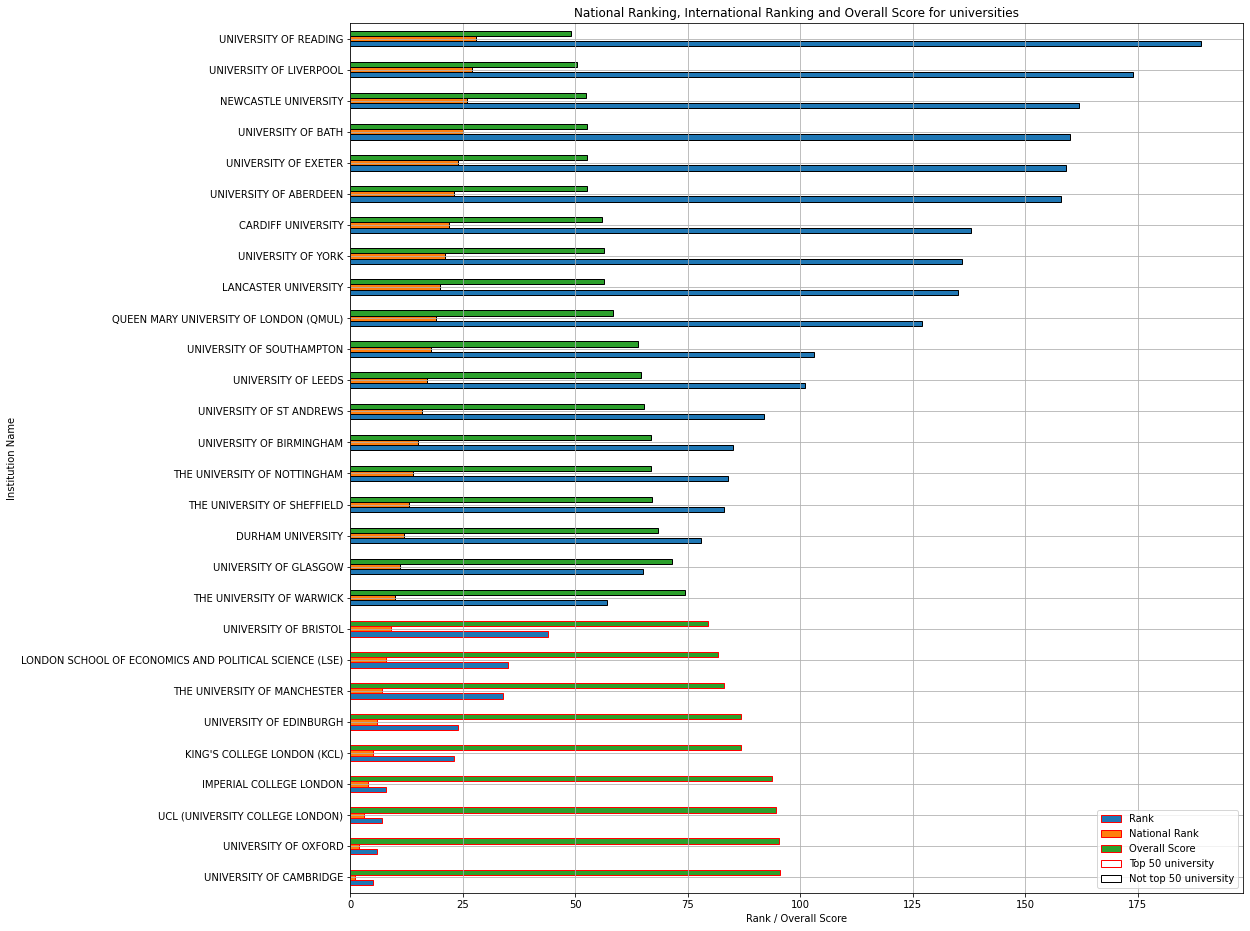

In [1]:
# CELL1 – 3 marks
################################################################################################################################
#  libraries needed for the coursework
%pylab inline
import pandas as pd
from pandas import Series, DataFrame
from scipy import stats
import statsmodels.api as sm
################################################################################################################################

uni_data=pd.read_excel("./2018-QS-World-University-Rankings-Top200.xlsx", index_col=None)
display(uni_data.head(10))

uk_unis = uni_data[uni_data['Location']=='United Kingdom']
data = pd.DataFrame(uk_unis[["Rank","Institution Name","Overall Score"]])

data["National Rank"] = np.arange(1,len(data)+1)
data["InTop50"] = data["Rank"] <= 50

colors = ["r" if InTop50==True else "0" for InTop50 in data.InTop50]

ax = data.plot.barh(x="Institution Name",y=["Rank","National Rank","Overall Score"], edgecolor = colors, figsize=(16,16))

xlabel("Rank / Overall Score")
ylabel("Institution Name")
grid()
handles, labels= ax.get_legend_handles_labels()
legend(handles=handles+[matplotlib.patches.Patch(facecolor="white", edgecolor="r", label="Top 50 university"),matplotlib.patches.Patch(facecolor="white", edgecolor="0", label="Not top 50 university")])
title("National Ranking, International Ranking and Overall Score for universities") 
show()

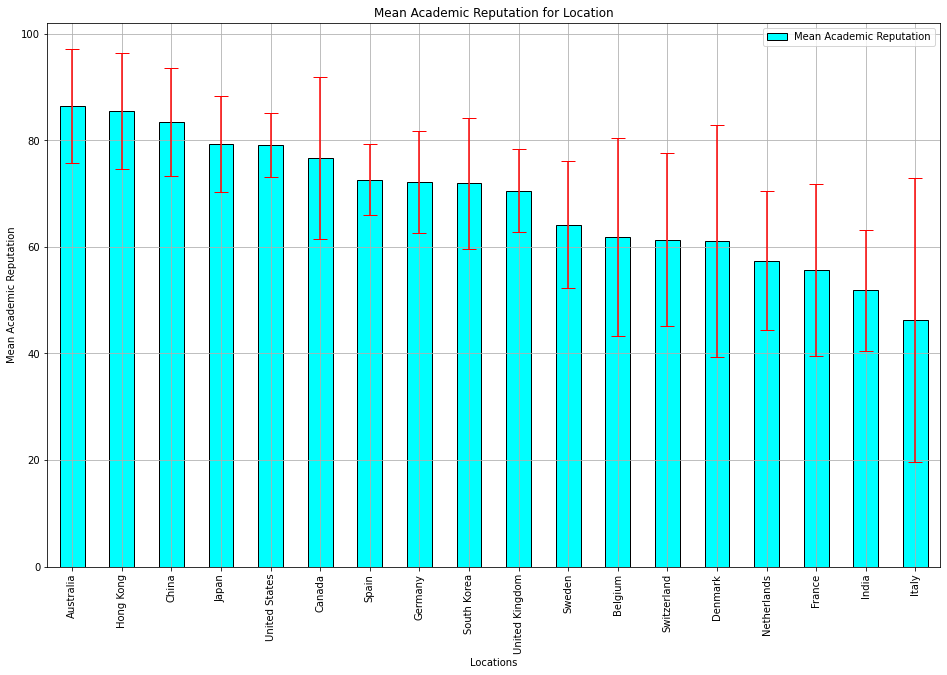

For each bar, the bar itself and the bar to the right of it are selected, they are then put through a shapiro test 
to test for normalisation at a confidence of 5%. If they are normal then significance is tested by a t-test at a 
confidence of 5%, if they are not normal then the significance is tested by using a mann-whitley test at 5%. We can
conclude that no bar is significantly higher than the bar to its right


In [2]:
# CELL2 – 3 marks
uniLocation=uni_data["Location"] 
uniLocationList = uniLocation.values
uniLocationList = list(dict.fromkeys(uniLocationList)) 

df = pd.DataFrame([])
appendedData = []

for i in uniLocationList:
    data = uni_data[uni_data["Location"]==i]["Academic Reputation"]
    if len(data) >= 3:
        locationMean=round(data.mean(),2)
        appendedData.append([i,locationMean, (1.96*np.std(data, ddof=0)/np.sqrt(len(data))), data.to_numpy(), False])  #ddof=1 gives same result as online calculator 

df = pd.concat([df,pd.DataFrame(appendedData)], axis=0, ignore_index=True)
df.columns = ["Locations","Mean Academic Reputation","Confidence","Data","Significant"]
df = df.sort_values(by=["Mean Academic Reputation"], axis=0, ascending=False).reset_index(drop=True)

for j in range(len(df["Locations"])-1):
    currentLocation = df.loc[j]["Data"]
    nextLocation = df.loc[j+1]["Data"]
    if (stats.shapiro(currentLocation).pvalue and stats.shapiro(nextLocation).pvalue)>=0.05:
        if stats.ttest_ind(currentLocation,nextLocation).pvalue < 0.05:
            df.loc[(j, "Significant")] = True 
        elif stats.mannwhitneyu(currentLocation,nextLocation).pvalue < 0.05:
            df.loc[(j, "Significant")] = True 

colors = ["r" if Significant==True else "cyan" for Significant in df.Significant]

ax = df.plot.bar(x="Locations",y="Mean Academic Reputation", yerr="Confidence", color=colors, capsize=7, edgecolor = 'black', ecolor="red",figsize=(16,10)) 

xlabel("Locations")
ylabel("Mean Academic Reputation")
title("Mean Academic Reputation for Location") 
grid()

show()

print("""For each bar, the bar itself and the bar to the right of it are selected, they are then put through a shapiro test 
to test for normalisation at a confidence of 5%. If they are normal then significance is tested by a t-test at a 
confidence of 5%, if they are not normal then the significance is tested by using a mann-whitley test at 5%. We can
conclude that no bar is significantly higher than the bar to its right""")

In [3]:
# CELL3 – 4 marks
uni_data2 = uni_data.dropna()
non_uk_unis = uni_data2[uni_data2['Location']!='United Kingdom'][["Institution Name","Rank","Academic Reputation", "Faculty Student","Citations per Faculty","Overall Score"]]
uk_test_data = uni_data[uni_data['Location']=='United Kingdom'][["Institution Name","Rank","Academic Reputation", "Faculty Student","Citations per Faculty","Overall Score"]]
pd.set_option('display.max_rows', 200)
#will give different result if Indian Institue is dropped

shorthand = {
    "Academic Reputation":"AR",
    "Employer Repuation":"ER",
    "Faculty Student":"FR",
    "Citations per Faculty":"CF",
    "International Faculty":"IF",
    "International Students":"IR"}

def regression(comb):
    comb = sm.add_constant(comb)
    results = sm.OLS(non_uk_unis["Overall Score"],comb).fit()
    return results
    
def printFormula(results):
    values = []
    intercept = []
    labels = results.summary2().tables[1]["Coef."].index.values

    for i in range(len(results.params)):
        if i == 0:
            intercept.append(round(results.params[i],2))
        else:
            values.append(round(results.params[i],2))

    toPrint = "OS = "
    for i in range(len(values)):
        if i == 0:
            toPrint+=str(values[i])+shorthand[labels[i+1]]+" "
        else:
            toPrint+="+ "+str(values[i])+shorthand[labels[i+1]]+" "
    toPrint+="+ "+str(intercept[0]) 
    return toPrint

def performanceEval(results,model):
    uk_comb = uk_test_data[model]
    uk_comb = sm.add_constant(uk_comb)
    aerror = abs(results.predict(uk_comb) - uk_test_data["Overall Score"])
    aerrors.append(aerror)
    mse=mean(aerror**2)
    toReturn = round(mse,2)
    return (toReturn)

possibleModels = [["Academic Reputation","Faculty Student","Citations per Faculty"],
                  ["Academic Reputation","Faculty Student"],
                  ["Academic Reputation","Citations per Faculty"],
                  ["Faculty Student","Citations per Faculty"]]
aerrors = []
addFormulas=[]
addMSE=[]

for i in possibleModels:
    print (printFormula(regression(non_uk_unis[i])))
    addFormulas.append(printFormula(regression(non_uk_unis[i])))
    addMSE.append(performanceEval(regression(non_uk_unis[i]),i))
    
dfResults = pd.DataFrame(list(zip(addFormulas,addMSE)),columns=["Model Equation", "MSE"])
    
display(dfResults)

print("Normality for AR, FR, CF =",stats.shapiro(aerrors[0]).pvalue,"> 0.05")
print("Normality for AR, FR =",stats.shapiro(aerrors[1]).pvalue,"> 0.05")
print("t-test for AR, FR, CF and AR, FR =",stats.ttest_ind(aerrors[0],aerrors[1]).pvalue,"> 0.05")

print("""There is no significant difference between using AR, FR and CR compared to just AR and FR at a 
5% confidence level therefore we should use the model with least number of variables to improve efficency""")


OS = 0.48AR + 0.21FR + 0.22CF + 4.73
OS = 0.52AR + 0.18FR + 17.56
OS = 0.48AR + 0.2CF + 18.63
OS = 0.2FR + 0.28CF + 36.74


,Model Equation,MSE
0,OS = 0.48AR + 0.21FR + 0.22CF + 4.73,24.32
1,OS = 0.52AR + 0.18FR + 17.56,22.49
2,OS = 0.48AR + 0.2CF + 18.63,49.16
3,OS = 0.2FR + 0.28CF + 36.74,116.01


Normality for AR, FR, CF = 0.9004761576652527 > 0.05
Normality for AR, FR = 0.10667043924331665 > 0.05
t-test for AR, FR, CF and AR, FR = 0.11912798542137536 > 0.05
There is no significant difference between using AR, FR and CR compared to just AR and FR at a 
5% confidence level therefore we should use the model with least number of variables to improve efficency


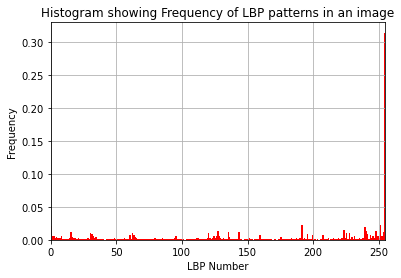

In [4]:
# CELL4 – 3 marks
img=imread("Model/m1.png")*255

tempCoords = [[-1,-1],[0,-1],[1,-1],[1,0],[1,1],[0,1],[-1,1],[-1,0]]

def generateHistogramData(img):
    lbpList = []      
    x=1
    y=1
    while y <= len(img)-2:
        lbp=""
        for position in tempCoords:
                if img[y][x] > img[y + position[1]][x + position[0]]:
                    lbp+="0"
                else:
                    lbp+="1"
        lbpValue = int(lbp[::-1],2)
        lbpList.append(lbpValue)
        x=x+1
        if x>= len(img[y])-1:
            x=1
            y=y+1
    return lbpList

lbpList = generateHistogramData(img)
bins = arange(0,256,1) 
histogram = hist(lbpList, bins, density=True, color="r")
xlim(0, 255)
figsize(16, 10)
xlabel("LBP Number")
ylabel("Frequency")
title("Histogram showing Frequency of LBP patterns in an image")
grid()
show()

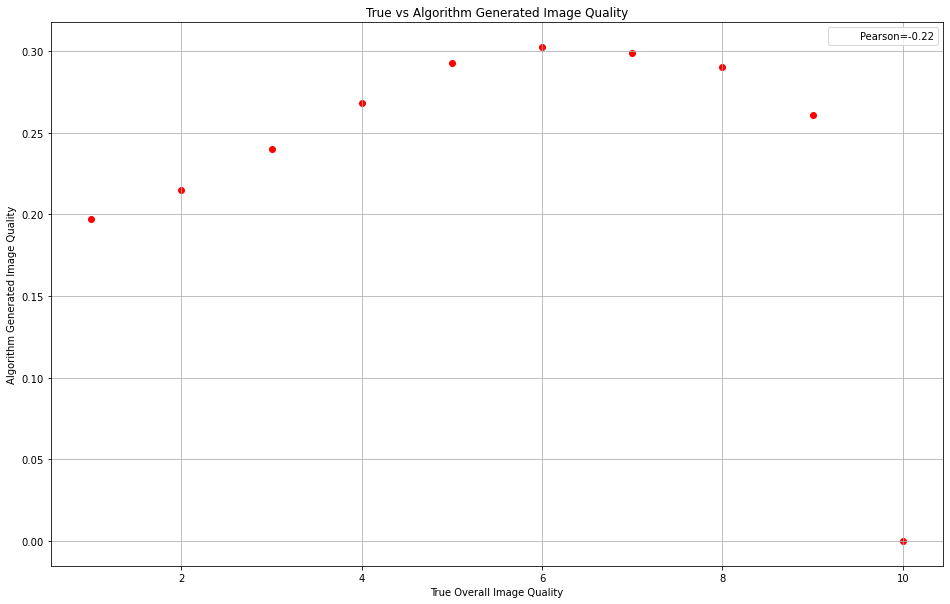

There is a negative and weak correlation therefore this model shouldnt be used


In [5]:
# CELL5 – 4 marks
img=imread("Model/m1.png")*255
referenceLBP = generateHistogramData(img)
true_img_quality=pd.read_excel("./Q_scores.xlsx", index_col=None)

def iqa(referenceLBP, imgName): 
    testLBP = generateHistogramData(imread(imgName)*255)
    referenceCounts = np.bincount(referenceLBP)
    testCounts = np.bincount(testLBP)
    bins = arange(0,256,1)
    referenceHist = np.column_stack((bins,referenceCounts[bins]/len(referenceLBP)))
    testHist = np.column_stack((bins,testCounts[bins]/len(testLBP)))
    diff = referenceHist[:,1] - testHist[:,1]
    sqDiff = diff * diff
    finalResult = sqrt(sum(sqDiff))
    return finalResult

imgList = ["Model/m1.png","Model/m2.png","Model/m3.png","Model/m4.png","Model/m5.png","Model/m6.png","Model/m7.png","Model/m8.png","Model/m9.png","Model/m10.png"]
algo_image_quality = []

for n in range(10):
    qualityIQA = iqa(referenceLBP,imgList[n])
    algo_image_quality.append(qualityIQA)

scatter(true_img_quality["Quality"], algo_image_quality, color="r",marker="o", edgecolors="r")
xlabel("True Overall Image Quality")
ylabel("Algorithm Generated Image Quality")
title("True vs Algorithm Generated Image Quality")

pearsonHandle = "Pearson="+str(round(stats.pearsonr(true_img_quality["Quality"],algo_image_quality)[0],2))
legend(handles=[matplotlib.patches.Patch(facecolor="white", edgecolor="white", label=pearsonHandle)])
grid()
show()
print("""There is a negative and weak correlation therefore this model shouldnt be used""")

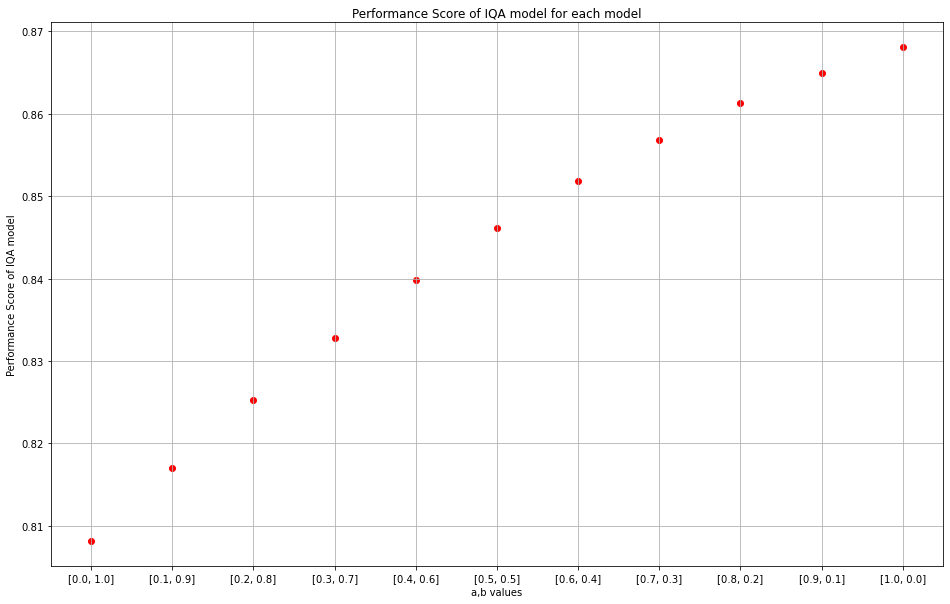

In [6]:
# CELL6 – 3 marks

true_img_quality=pd.read_excel("./Q_scores.xlsx", index_col=None)

imgList = ["Model/m1.png","Model/m2.png","Model/m3.png","Model/m4.png","Model/m5.png","Model/m6.png","Model/m7.png","Model/m8.png","Model/m9.png","Model/m10.png"]

model = []
performanceScore = []

def altIQA(testImage):
    AP = mean(testImage)
    MP = median(testImage)
    IQp = a*AP + b*MP
    return IQp

for i in range(0,11,1):
    a = round(i*0.1,2)
    b = round(1-a,2)
    IQpScore = []
    model.append(str([a,b]))
    for j in imgList:
        img=imread(j)*255
        IQpScore.append(altIQA(img))
    performanceScore.append(stats.pearsonr(true_img_quality["Quality"],IQpScore)[0])
    
scatter(model, performanceScore, color="r",marker="o", edgecolors="r")
xlabel("a,b values")
ylabel("Performance Score of IQA model")
title("Performance Score of IQA model for each model")
grid()
show()


In [7]:
import scipy
print(scipy.__version__)

1.9.1
